In [1]:
!pip install --upgrade pip
!pip install -U -q torch torchvision scipy tdqm matplotlib scipy transformers

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 69.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dep

# Google Drive Mount

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Import Modules

In [3]:
import torch
import torch.nn as nn

import numpy as np

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

from scipy.linalg import sqrtm
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

### Print Functions

In [39]:
def image_normalize(image):
    image = image.cpu()
    n_channels = image.shape[0]
    for channel in range(n_channels):
        max_value = torch.max(image[channel])
        min_value = torch.min(image[channel])
        image[channel] = (image[channel] - min_value) / (max_value - min_value)

    image = image.permute(1, 2, 0)

    return image

def print_image(image):
    image = image_normalize(image)
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()

def print_2images(image1, image2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_normalize(image1))
    axes[0].set_title('Image 1')

    axes[1].imshow(image_normalize(image2))
    axes[1].set_title('Image 2')

    plt.tight_layout()
    plt.show()

def print_digits(result):
    fig, axes = plt.subplots(1, 10, figsize=(10, 5))

    B = result.shape[0]
    for i in range(B):
        axes[i].imshow(image_normalize(result[i]))
        axes[i].set_title(i)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def print_result(result):
    for original_image, noised_image, denoised_image in result:
        batch_size = original_image.shape[0]
        for idx in range(batch_size):
            print_2images(original_image[idx], denoised_image[idx])
            # print_image(image[idx])
            # print_image(noised_image[idx])
            # print_image(denoised_image[idx])


def print_loss(loss_values,
               label='Training Loss',
               x_label='Epoch',
               y_label='Loss',
               title='Loss vs. Epochs'):
    epochs = list(range(1, len(loss_values) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss_values, 'b-o', label=label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

### Torch Device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Evaluations

In [6]:
from transformers import pipeline

CLASSIFIER_MODEL = pipeline(
    "image-classification",
    model="farleyknight-org-username/vit-base-mnist",
    device=device
)

def inception_ViT(inputs):

    def convert_to_pil(x):
        converted_images = []
        for i in range(x.shape[0]):
            converted_images.append(to_pil_image(x[i]))
        return converted_images

    def convert_classifier_results(results):
        prob = [0.00000001] * 10
        for result in results:
            prob[int(result['label'])] = result['score']
        return prob

    # inputs : [B, 1, 32, 32]
    out = CLASSIFIER_MODEL(convert_to_pil(inputs))
    out = [convert_classifier_results(x) for x in out]
    return out

# Function to get inception features
def get_inception_features(inception_model, result):
    target, origin = [], []

    for original_image, noised_image, denoised_image in result:
        # denoised_image : [B, 1, 32, 32]
        origin += inception_model(original_image)
        target += inception_model(denoised_image)

    return origin, target

# Calculate FID
def calculate_fid(origin, target):
    mu1, sigma1 = np.mean(origin, axis=0), np.cov(origin, rowvar=False)
    mu2, sigma2 = np.mean(target, axis=0), np.cov(target, rowvar=False)
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

def calculate_inception_score(results):
    scores = []
    for part in results:
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([np.sum(p * np.log(p / py)) for p in part])))
    return np.mean(scores), np.std(scores)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/985 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

In [7]:
def print_scores(result):
    origin, target = get_inception_features(inception_ViT, result)

    origin_IS_mean, origin_IS_std = calculate_inception_score(origin)
    print(f'[Origin] IS: {origin_IS_mean} ± {origin_IS_std}')

    target_IS_mean, target_IS_std = calculate_inception_score(target)
    print(f'[Target] IS: {target_IS_mean} ± {target_IS_std}')

    FID = calculate_fid(origin, target)
    print(f'FID: {FID}')

    return origin_IS_mean, target_IS_mean, FID

# Noise Scheduler
- betas, alphas

In [8]:
class NoiseSchedule:

    def __init__(
        self,
        n_timesteps,
        beta_start = 0.0001,
        beta_end = 0.02,
        device = device,
        init_type = "linear"
    ) -> None:

        self._size = n_timesteps
        if init_type == "linear":
            self._betas = torch.linspace(beta_start, beta_end, n_timesteps).to(device)
        if init_type == "exponential":
            self._betas = torch.from_numpy(np.geomspace(beta_start, beta_end, n_timesteps)).to(device)
        self._alphas = self._calculate_alphas()

    def _calculate_alphas(self):
        self._alphas = torch.cumprod(1 - self._betas, axis=0)
        return self._alphas

# Forward Encoder

In [9]:
class ForwardEncoder:

    def __init__(self, noise_schedule) -> None:
        self.noise_schedule = noise_schedule

    def noise(self, data, time_step):
        # time_step : [B]
        # data : [B, 1, 32, 32]

        alpha = self.noise_schedule._alphas[time_step]
        alpha = alpha.reshape(-1, 1, 1, 1)
        # alpha : [B, 1, 1, 1]

        epsilon = torch.randn(data.shape).to(device)
        # torch.randn ~ N(0, 1)

        return torch.sqrt(alpha) * data + torch.sqrt(1 - alpha) * epsilon, epsilon

# Reverse Decoder

In [51]:
import torch

class ReverseDecoder:

    def __init__(
        self,
        noise_schedule,
        g
    ) -> None:
        self.noise_schedule = noise_schedule
        self.g = g

    def DDPM_sampling(
        self,
        noise_data,
        time_step,
        c = None,
        w = 0
    ):
        # noise_data : [B, 1, 32, 32]
        # c : [B]
        # time_step : INT

        batch_size = noise_data.shape[0]
        # batch_size : B

        with torch.no_grad():

            # step : [T - 1, T - 2, .. 2, 1, 0]
            for step in range(time_step - 1, -1, -1):

                t = torch.full((batch_size, ), step).to(device)
                t = t.reshape(-1, 1, 1, 1)
                # t : [B, 1, 1, 1]

                predict_noise = (1 + w) * self.g(noise_data, t, c) - w * self.g(noise_data, t)
                mu = 1 / torch.sqrt(1 - self.noise_schedule._betas[t]) * (noise_data - (self.noise_schedule._betas[t] / (1 - self.noise_schedule._alphas[t])) * predict_noise)
                # mu : [B, 1, 32, 32]

                if step == 0:
                    # if t == 0, no add noise
                    break

                epsilon = torch.randn(noise_data.shape).to(device)
                # epsilon : [B, 1, 32, 32]

                noise_data = mu + torch.sqrt(self.noise_schedule._betas[t]) * epsilon
                # noise_data : [B, 1, 32, 32]

        return noise_data

    def DDIM_sampling(
        self,
        noise_data,
        time_step,
        c = None,
        w = 0,
        sampling_time_step = 10,
        custom_sampling_steps = None
    ):
        # noise_data : [B, 1, 32, 32]
        # c : [B]
        # time_step : INT

        batch_size = noise_data.shape[0]
        tau = list(range(0, time_step, time_step // sampling_time_step))
        if custom_sampling_steps is not None:
            tau = custom_sampling_steps

        S = len(tau)

        origin_noise_data = noise_data.clone()
        history_with_origin = []
        history_with_prev = []

        # batch_size : B
        with torch.no_grad():

            # step : [T - 1, T - 2, .. 2, 1, 0]
            for i in range(S - 1, -1, -1):

                t = torch.full((batch_size, ), tau[i]).to(device)
                t = t.reshape(-1, 1, 1, 1)
                alpha_t = self.noise_schedule._alphas[t]

                alpha_t_1 = torch.full((batch_size, 1, 1, 1,), 1).to(device)
                if i - 1 >= 0:
                    t_1 = torch.full((batch_size, ), tau[i - 1]).to(device)
                    t_1 = t_1.reshape(-1, 1, 1, 1)
                    alpha_t_1 = self.noise_schedule._alphas[t_1]

                predict_noise = (1 + w) * self.g(noise_data, t, c) - w * self.g(noise_data, t)
                first = torch.sqrt(alpha_t_1) * ((noise_data - torch.sqrt(1 - alpha_t) * predict_noise) / torch.sqrt(alpha_t))
                second = torch.sqrt(1 - alpha_t_1) * predict_noise

                history_with_origin.append(torch.norm(origin_noise_data - noise_data))
                history_with_prev.append(torch.norm(first + second - noise_data))
                noise_data = first + second

        torch.save(torch.tensor(history_with_origin), "diff_norm_origin.pt")
        torch.save(torch.tensor(history_with_prev), "diff_norm_prev.pt")
        return noise_data

# UNet

### Backbones

In [28]:
class PositionalEmbedding(nn.Module):

    def __init__(self, num_steps, time_emb_dim) -> None:
        super(PositionalEmbedding, self).__init__()

        self.time_embed = nn.Embedding(num_steps, time_emb_dim)
        self.time_embed.weight.data = self.sinusoidal_embedding(num_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

    def sinusoidal_embedding(self, n, d):
        # Returns the standard positional embedding
        embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
        sin_mask = torch.arange(0, n, 2)
        embedding[sin_mask] = torch.sin(embedding[sin_mask])
        embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

        return embedding

    def forward(self, input):
        return self.time_embed(input)


class WideResNetBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        is_batchnorm = True,
        n = 3,
        kernel_size = 3,
        stride = 1,
        padding = 1,
        num_groups = 32
    ):
        super(WideResNetBlock, self).__init__()
        self.n = n
        self.ks = kernel_size
        self.stride = stride
        self.padding = padding

        self.shortcut = nn.Sequential()
        if kernel_size != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(num_groups=num_groups, num_channels=out_channels)
                # nn.BatchNorm2d(out_size)
            )

        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                    #  nn.BatchNorm2d(out_size),
                    nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
                    nn.SiLU(inplace=True)
                )
                setattr(self, 'conv%d' % i, conv)
                in_channels = out_channels

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                    nn.SiLU(inplace=True)
                )
                setattr(self, 'conv%d' % i, conv)
                in_channels = out_channels


    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)
        x += self.shortcut(inputs)
        return x


class MultiHeadAttentionBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        is_batchnorm = True,
        num_heads = 2,
        num_groups = 32,
    ):
        super(MultiHeadAttentionBlock, self).__init__()

        self.is_batchnorm = is_batchnorm
        # For each of heads use d_k = d_v = d_model / num_heads
        self.num_heads = num_heads
        self.d_model = out_channels
        self.d_keys = out_channels // num_heads
        self.d_values = out_channels // num_heads

        self.W_Q = nn.Linear(in_channels, out_channels, bias=False)
        self.W_K = nn.Linear(in_channels, out_channels, bias=False)
        self.W_V = nn.Linear(in_channels, out_channels, bias=False)

        self.final_projection = nn.Linear(out_channels, out_channels, bias=False)
        self.norm = nn.GroupNorm(num_channels=out_channels, num_groups=num_groups)

    def split_features_for_heads(self, tensor):
        batch, hw, emb_dim = tensor.shape
        channels_per_head = emb_dim // self.num_heads
        heads_splitted_tensor = torch.split(tensor, split_size_or_sections=channels_per_head, dim=-1)
        heads_splitted_tensor = torch.stack(heads_splitted_tensor, 1)
        return heads_splitted_tensor

    def attention(self, q, k, v):

        B, C, H, W = q.shape
        q = q.view(B, C, q.shape[2] * q.shape[3]).transpose(1, 2)
        k = k.view(B, C, k.shape[2] * k.shape[3]).transpose(1, 2)
        v = v.view(B, C, v.shape[2] * v.shape[3]).transpose(1, 2)

        # [B, H * W, C_in]

        q = self.W_Q(q)
        k = self.W_K(k)
        v = self.W_V(v)
        # N = H * W
        # [B, N, C_out]

        Q = self.split_features_for_heads(q)
        K = self.split_features_for_heads(k)
        V = self.split_features_for_heads(v)
        # [B, num_heads, N, C_out / num_heads]

        scale = self.d_keys ** -0.5
        attention_scores = torch.softmax(torch.matmul(Q, K.transpose(-1, -2)) * scale, dim=-1)
        attention_scores = torch.matmul(attention_scores, V)
        # [B, num_heads, N, C_out / num_heads]

        attention_scores = attention_scores.permute(0, 2, 1, 3).contiguous()
        # [B, num_heads, N, C_out / num_heads] --> [B, N, num_heads, C_out / num_heads]

        concatenated_heads_attention_scores = attention_scores.view(B, H * W, self.d_model)
        # [B, N, num_heads, C_out / num_heads] --> [batch, N, C_out]

        linear_projection = self.final_projection(concatenated_heads_attention_scores)
        linear_projection = linear_projection.transpose(-1, -2).reshape(B, self.d_model, H, W)
        # [B, N, C_out] -> [B, C_out, N] -> [B, C_out, H, W]

        # Residual connection + norm
        out = linear_projection
        if self.is_batchnorm:
            v = v.transpose(-1, -2).reshape(B, self.d_model, H, W)
            out = self.norm(out + v)
        return out

    def forward(self, q, k, v):
        return self.attention(q, k, v)


class SelfAttentionBlock(MultiHeadAttentionBlock):
    def __init__(
        self,
        in_channels,
        out_channels,
        is_batchnorm = True,
        num_heads = 2,
        num_groups = 32,
    ):
        super().__init__(in_channels, out_channels, num_heads, num_groups)


    def forward(self, x):
        return super().forward(x, x, x)

### UNet Body

In [29]:
class UNetDown(nn.Module):

    def __init__(
        self,
        in_channels,
        out_channels,
        base_model = WideResNetBlock,
        is_deconv = True,
        is_batchnorm = True
    ):
        super(UNetDown, self).__init__()
        self.conv = base_model(in_channels, out_channels, is_batchnorm=is_batchnorm)

    def forward(self, input):
        return self.conv(input)


class UNetUp(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        base_model = WideResNetBlock,
        is_deconv = True,
        is_batchnorm = True
    ):
        super(UNetUp, self).__init__()
        self.conv = base_model(out_channels * 2, out_channels, is_batchnorm=is_batchnorm)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs0, *input):
        outputs0 = self.up(inputs0)
        for i in range(len(input)):
            outputs0 = torch.cat([outputs0, input[i]], 1)
        return self.conv(outputs0)


class UNetTimeEmbedding(nn.Module):

    def __init__(self, dim_in, dim_out) -> None:
        super(UNetTimeEmbedding, self).__init__()
        self.ln = nn.Linear(dim_in, dim_out)
        self.activation = nn.SiLU()
        self.ln2 = nn.Linear(dim_out, dim_out)


    def forward(self, inputs):
        B = inputs.shape[0]

        x = self.ln(inputs)
        x = self.activation(x)
        x = self.ln2(x)

        return x.reshape(B, -1, 1, 1)


class UNet(nn.Module):

    def __init__(
        self,
        in_channels = 1,
        out_channels = 1,
        n_steps = 1000,
        time_emb_dim = 256,
        n_classes = 10,
        class_emb_dim = 64,
        channel_scale = 64,
        num_channel_scale = 5,
        custom_channel_scale = None,
        cross_attention_layer_indices = [-1],
        self_attention_layer_indices = [-1],
        is_deconv = True,
        is_batchnorm = True
    ):
        super(UNet, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.is_batchnorm = is_batchnorm

        self.self_attention_layer_indices = set(self_attention_layer_indices)
        self.cross_attention_layer_indices = set(cross_attention_layer_indices)

        # time embedding
        self.time_embedding = PositionalEmbedding(n_steps, time_emb_dim)

        # conditional variable embedding
        self.context_embedding = PositionalEmbedding(n_classes, class_emb_dim)

        if custom_channel_scale is None:
            # channel exponenetial scales with `channel_scale`
            # 64, 128, 256, 512, 1024
            filters = [channel_scale * (2 ** i) for i in range(num_channel_scale)]
        else:
            # custom channel scales
            num_channel_scale = len(custom_channel_scale)
            filters = custom_channel_scale

        self.num_layers = num_channel_scale

        # Downsampling
        filters.insert(0, in_channels)

        for layer_idx in range(1, self.num_layers):
            base_model = WideResNetBlock
            if (layer_idx - self.num_layers) in self.self_attention_layer_indices:
                base_model = SelfAttentionBlock

            conv = UNetDown(in_channels=filters[layer_idx - 1],
                            out_channels=filters[layer_idx],
                            is_batchnorm=self.is_batchnorm,
                            base_model=base_model)
            temb = UNetTimeEmbedding(time_emb_dim, filters[layer_idx])
            cemb = UNetTimeEmbedding(class_emb_dim, filters[layer_idx])
            maxpool = nn.MaxPool2d(kernel_size=2)
            if (layer_idx - self.num_layers) in self.cross_attention_layer_indices:
                cross_attention = MultiHeadAttentionBlock(
                    in_channels=filters[layer_idx],
                    out_channels=filters[layer_idx],
                    is_batchnorm=False
                )
                setattr(self, 'down_cross_attention%d' % layer_idx, cross_attention)

            setattr(self, 'down_conv%d' % layer_idx, conv)
            setattr(self, 'down_temb%d' % layer_idx, temb)
            setattr(self, 'down_cemb%d' % layer_idx, cemb)
            setattr(self, 'down_maxpool%d' % layer_idx, maxpool)


        # Bottleneck

        self.center = UNetDown(filters[-2], filters[-1], is_batchnorm=self.is_batchnorm)
        self.temb_center = UNetTimeEmbedding(time_emb_dim, filters[-1])
        self.cemb_center = UNetTimeEmbedding(class_emb_dim, filters[-1])
        self.cross_attention_center = MultiHeadAttentionBlock(
            in_channels=filters[-1],
            out_channels=filters[-1],
            is_batchnorm=False
        )

        # upsampling
        filters[0] = out_channels

        for layer_idx in range(1, self.num_layers):
            base_model = WideResNetBlock
            if (layer_idx - self.num_layers) in self.self_attention_layer_indices:
                base_model = SelfAttentionBlock
            conv = UNetUp(filters[layer_idx + 1],
                          filters[layer_idx],
                          is_deconv=self.is_deconv,
                          is_batchnorm=self.is_batchnorm,
                          base_model=base_model)
            temb = UNetTimeEmbedding(time_emb_dim, filters[layer_idx])

            setattr(self, 'up_conv%d' % layer_idx, conv)
            setattr(self, 'up_temb%d' % layer_idx, temb)

        # output
        self.outconv = nn.Conv2d(filters[1], self.out_channels, 3, padding=1)


    def forward(
        self,
        inputs,
        t,
        c = None
    ):

        t = self.time_embedding(t)
        if c is not None:
            c = self.context_embedding(c)

        # inputs : [B, 1, 32, 32]

        x = inputs
        downsampling_result = [None]

        # DOWN-SAMPLING
        for layer_idx in range(1, self.num_layers):

            conv = getattr(self, 'down_conv%d' % layer_idx)
            temb = getattr(self, 'down_temb%d' % layer_idx)
            cemb = getattr(self, 'down_cemb%d' % layer_idx)
            maxpool = getattr(self, 'down_maxpool%d' % layer_idx)

            x = conv(x)
            downsampling_result.append(x)

            if c is not None and (layer_idx - self.num_layers) in self.cross_attention_layer_indices:
                CA = getattr(self, 'down_cross_attention%d' % layer_idx)
                context_emb = cemb(c)
                x = CA(x, context_emb, context_emb)

            x += temb(t)
            x = maxpool(x)

        # BOTTLENECK

        x = self.center(x)
        if c is not None:
            context_emb = self.cemb_center(c)
            x = self.cross_attention_center(x, context_emb, context_emb)
        x += self.temb_center(t)

        # UP-SAMPLING

        for layer_idx in range(self.num_layers - 1, 0, -1):
            conv = getattr(self, 'up_conv%d' % layer_idx)
            temb = getattr(self, 'up_temb%d' % layer_idx)
            x = conv(x, downsampling_result[layer_idx])
            x += temb(t)

        return self.outconv(x)

# Diffusion

In [30]:
class MyDiffusion:

    def __init__(
        self,
        n_timesteps,
        train_set = None,
        test_set = None,
        in_channels = 1,
        out_channels = 1,
        channel_scale = 64,
        num_channle_scale = 5,
        train_batch_size = 8,
        test_batch_size = 8,
        custom_channel_scale = None,
        learning_rate = 0.0001
    ):

        self.n_timesteps = n_timesteps
        self.channel_scale = channel_scale

        # UNet for predicting total noise
        self.g = UNet(in_channels=in_channels,
                      out_channels=out_channels,
                      n_steps=n_timesteps,
                      channel_scale=channel_scale,
                      num_channel_scale=num_channle_scale,
                      custom_channel_scale=custom_channel_scale)
        self.g = self.g.to(device)

        # alpha, betas
        self.noise_schedule = NoiseSchedule(n_timesteps=n_timesteps)

        # forward encoder
        self.encoder = ForwardEncoder(noise_schedule=self.noise_schedule)
        self.decoder = ReverseDecoder(noise_schedule=self.noise_schedule, g=self.g)

        # optimizer
        self.lossFunction = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.g.parameters(), lr=learning_rate)

        # datasets
        if train_set:
            self.training_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
        if test_set:
            self.testing_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=True)


    def save(self, path='./model.pt'):
        torch.save(self.g.state_dict(), path)


    def load(self, path='./model.pt'):
        self.g.load_state_dict(torch.load(path))
        self.g.eval()


    def train_one_epoch(
        self,
        n_iter_limit = None,
        p_uncond = 0.1
    ):

        running_loss = 0

        for i, data in enumerate(tqdm(self.training_loader)):

            # inputs = [B, 1, 32, 32]
            inputs, label = data
            inputs = inputs.to(device)
            # print(inputs.shape)

            batch_size = inputs.shape[0]

            # sampled timestep and conditional variables
            t = torch.randint(0, self.n_timesteps, (batch_size, )).to(device)
            c = label.to(device)

            # outputs = [B, 1, 28, 28]
            noised_image, epsilon = self.encoder.noise(inputs, t)

            outputs = None
            if torch.rand((1, )).item() < p_uncond:
                outputs = self.g(noised_image, t)
            else:
                outputs = self.g(noised_image, t, c)

            loss = self.lossFunction(outputs, epsilon)

            # Adjust learning weights
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

            if i == n_iter_limit:
                break

        return running_loss / len(self.training_loader)


    def train(
        self,
        n_epoch = 5,
        n_iter_limit = None,
        p_uncond = 0.1
    ):

        history = []

        for epoch in range(n_epoch):
            print('EPOCH {}:'.format(epoch + 1))

            # Make sure gradient tracking is on, and do a pass over the data
            self.g.train(True)
            avg_loss = self.train_one_epoch(n_iter_limit=n_iter_limit,
                                            p_uncond=p_uncond)
            history.append(avg_loss)
            print('# epoch {} avg_loss: {}'.format(epoch + 1, avg_loss))

            model_path = 'U{}_T{}_E{}.pt'.format(self.channel_scale,
                                                             self.n_timesteps,
                                                             epoch + 1)
            torch.save(self.g.state_dict(), model_path)
            torch.save(torch.tensor(history), 'history.pt')

        return history


    def evaluate(
        self,
        epochs = None,
        sampling_type = "DDPM",
        sampling_time_step = 10,
        w = 0
    ):
        self.decoder.g = self.g
        result = []
        for i, data in enumerate(tqdm(self.testing_loader)):

            # inputs = [B, 1, 32, 32]
            inputs, label = data # data['image']
            inputs = inputs.to(device)

            batch_size = inputs.shape[0]

            # timestep
            t = torch.full((batch_size, ), self.n_timesteps - 1).to(device)
            c = label.to(device)

            # outputs = [B, 1, 28, 28]
            noised_image, epsilon = self.encoder.noise(inputs, t)

            # denoised image
            denoised_image = None
            if sampling_type == "DDPM":
                denoised_image = self.decoder.DDPM_sampling(
                    noised_image,
                    self.n_timesteps,
                    c=c,
                    w=w
                )
            if sampling_type == "DDIM":
                denoised_image = self.decoder.DDIM_sampling(
                    noised_image,
                    self.n_timesteps,
                    c=c,
                    w=w,
                    sampling_time_step=sampling_time_step
                )

            result.append((inputs, noised_image, denoised_image))

            if i == epochs - 1:
                break

        return result

# Train

In [52]:
TIME_STEPS = 1000
BATCH_SIZE = 512
EPOCHS = 30
P_UNCOND = 0.1

noise_schedule = NoiseSchedule(
    n_timesteps=TIME_STEPS,
    init_type="exponential"
)

In [53]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train = MNIST(root='./data', train=True, download=True, transform=transform)
test = MNIST(root='./data', train=False, download=True, transform=transform)

In [54]:
model = MyDiffusion(
    n_timesteps=TIME_STEPS,
    in_channels=1,
    out_channels=1,
    custom_channel_scale=[128, 128, 256, 256, 512, 512],
    train_set=train,
    test_set=test,
    train_batch_size=BATCH_SIZE,
    test_batch_size=8
)

MODEL_PATH = '/content/drive/My Drive/models/DDPM_MNIST/UCA128_T1000_E30_v2.pt'
model.load(MODEL_PATH)

<ipython-input-30-70dc5bc478d4>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.g.load_state_dict(torch.load(path))


In [18]:
print("model size : ", sum(p.numel() for p in model.g.parameters() if p.requires_grad))

model size :  33119361


In [19]:
# history = model.train(
#     n_epoch=EPOCHS,
#     p_uncond=P_UNCOND
# )

# Generated Image

In [42]:
test_noise = torch.randn((1, 1, 32, 32)).to(device)
test_noise = test_noise.repeat(10, 1, 1, 1)

condition = torch.tensor(list(range(10))).to(device)

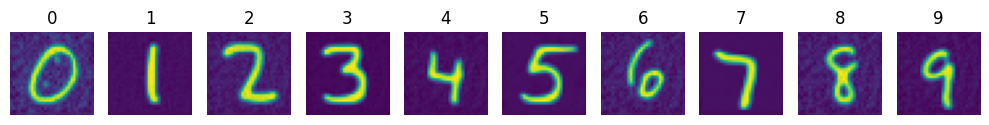

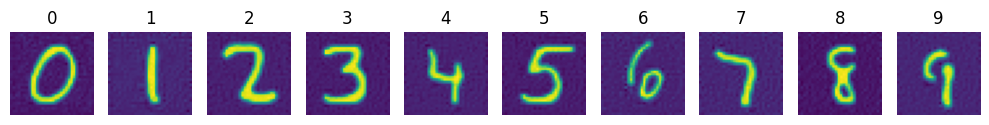

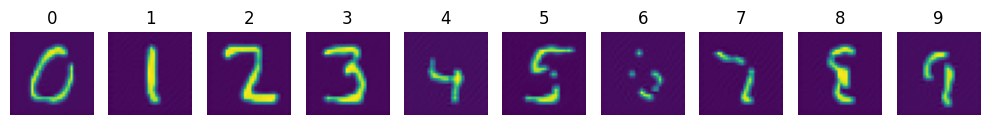

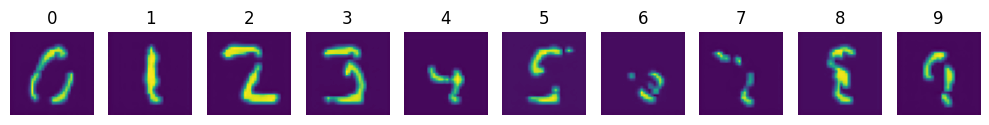

In [43]:
test_steps = [10, 20, 50, 100]

for steps in test_steps:
    test_denoised_image = model.decoder.DDIM_sampling(
        test_noise,
        TIME_STEPS,
        c=condition,
        w=1,
        sampling_time_step=steps
    )

    print_digits(test_denoised_image)

# Experiments

In [55]:
test_noise = torch.randn((1, 1, 32, 32)).to(device)
test_noise = test_noise.repeat(10, 1, 1, 1)

condition = torch.tensor(list(range(10))).to(device)

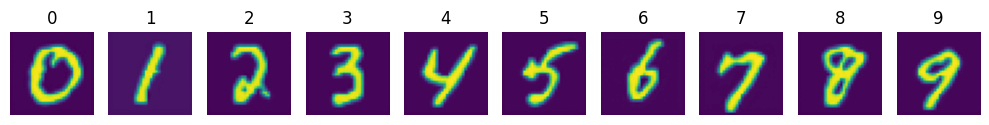

In [56]:
test_denoised_image = model.decoder.DDIM_sampling(
    test_noise,
    TIME_STEPS,
    c=condition,
    w=1,
    sampling_time_step=100
)

print_digits(test_denoised_image)

<ipython-input-57-7d51f5179dfa>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diff_norm = torch.load("diff_norm_origin.pt")


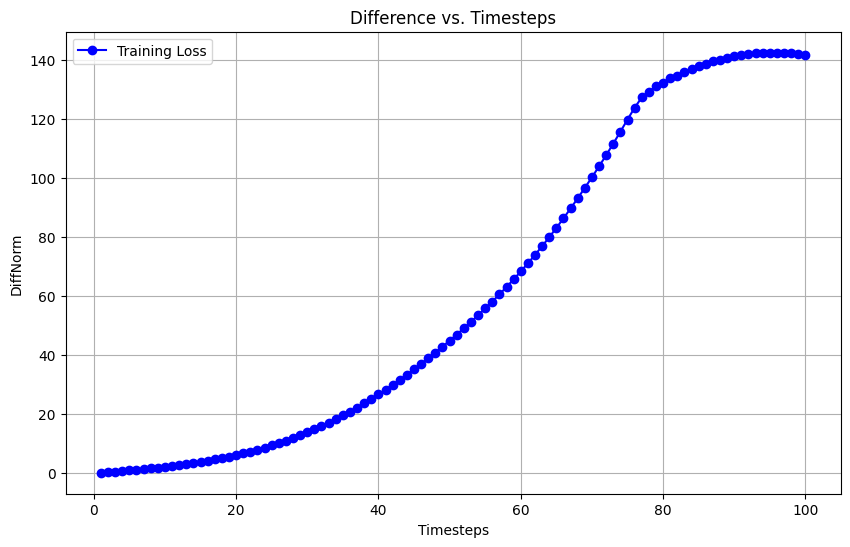

In [57]:
diff_norm = torch.load("diff_norm_origin.pt")
print_loss(diff_norm,
           title='Difference vs. Timesteps (origin)',
           x_label='Timesteps',
           y_label='DiffNorm')

<ipython-input-58-e3ef775c5041>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diff_norm = torch.load("diff_norm_prev.pt")


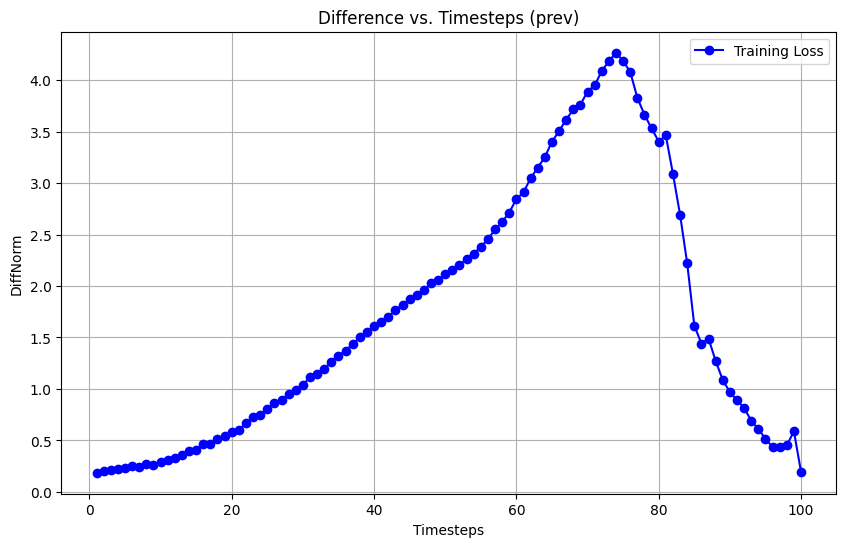

In [58]:
diff_norm = torch.load("diff_norm_prev.pt")
print_loss(diff_norm,
           title='Difference vs. Timesteps (prev)',
           x_label='Timesteps',
           y_label='DiffNorm')